# This notebook will remake some of the figures from the paper, for the fake data.  

First step: basic imports, along with some `rcParams` settings to make plots look nicer (to my eye).

In [1]:
import numpy as np
import calc_nonlin_coefs as nonlin
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy import interpolate, stats

from matplotlib import rcParams

rcParams['font.size'] = 16
rcParams['savefig.facecolor'] = 'white'
rcParams['axes.labelsize'] = 16
rcParams['xtick.direction'] = 'in'
rcParams['xtick.minor.visible'] = True
rcParams['ytick.direction'] = 'in'
rcParams['ytick.right'] = True
rcParams['ytick.minor.visible'] = True
rcParams['lines.linewidth'] = 3

Read in the ramps and cast to floating point: data shape is (nramps, nreads, npixels).  Put in the adopted pedestal of 5000 counts.

The only file you will need to run this notebook is `calc_nonlin_coefs.py`.

In [2]:
samectrate = True
if samectrate:
    ramps_synthetic = fits.open('synthetic_ramps_samecountrate.fits')[0].data.astype(float)
else:
    ramps_synthetic = fits.open('synthetic_ramps_variablecountrate.fits')[0].data.astype(float)
ramps_input = ramps_synthetic

pedestal = np.zeros(ramps_input[0, 0].shape)
pedestal[:] = 5000

This function returns the best-fit ramp so that it can be fit without the full noise realization.

The extensions on the domain can be problematic at high polynomial orders, where the function may not be invertible.

In [3]:
def getramps(ramps, res, pedestals):

    npixels = ramps.shape[-1]
    coefs = res.nonlin_coefs

    allfits = np.zeros(ramps.shape)
    for i in range(npixels):
        # Numerically invert 
        ymeas = np.linspace(np.amin(ramps[..., i]) - pedestals[i] - 200, 
                            np.amax(ramps[..., i]) - pedestals[i] + 200, 
                            1000)
        ycorr = ymeas*0.

        for j in range(res.order):
            ycorr += coefs[i, j]*ymeas**(j + 1)

        f = interpolate.interp1d(ycorr, ymeas, kind='cubic',
                                bounds_error=False, fill_value=65535)

        fit = f(res.slopes[i][:ramps.shape[0], None]*np.arange(1, ramps.shape[1] + 1)[None, :])

        allfits[..., i] = fit + pedestals[i]

    return allfits

Parameters that we will use for the plots.  You can change the boolean variables `show_rel` and `plot_many` to make the plot look different.

Note that there are some hardcoded lines and somewhat inelegant constructs here.  This code is not meant to generalize beyond the specific case at hand.

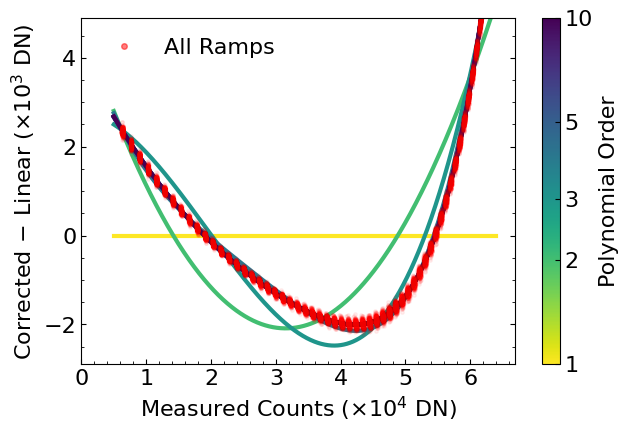

<Figure size 640x480 with 0 Axes>

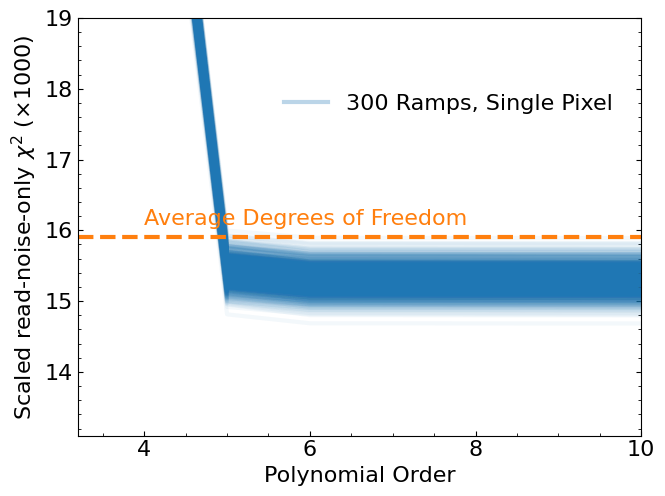

In [4]:
ipix = 15          # This is the pixel we will use for our plots.

show_rel = True    # Plot things relative to the linear fit?
plot_many = True   # Plot all ramps at once?
max_order = 10     # Maximum polynomial order
satval = 6.4e4     # Adopted saturation value: we fit everything up to this level.
readstart = 0      # First read (indexed from zero) that we use
iramp = 100        # If we plot the residuals for just one ramp, which one?

sig = 5*np.ones(pedestal.shape)   # Single-read read noise
gain = 1.8*np.ones(pedestal.shape)   # Gain (electrons/DN)

ramps = ramps_input[:, readstart:]

if show_rel:
    fig, (ax) = plt.subplots(1, 1, figsize=(7, 4.5))
    fac = 10
else:
    fig, (ax) = plt.subplots(1, 1)
    fac = 1

ref = 0
chisq_list = []
order_list = []
for order in np.arange(1, max_order + 1):
    
    # Fit for the nonlinearity parameter twice.  First, so that we
    # get a reasonably good estimate of the count rates in order to
    # get the covariance matrices right, then a second time to get
    # the answer.
    
    res = nonlin.get_nonlin_coefs(ramps, sig, gain, order, pedestal,
                                   satval=satval)

    res = nonlin.get_nonlin_coefs(ramps, sig, gain, order, pedestal,
                                   satval=satval, last_pars=res)

    coefs = res.nonlin_coefs[ipix]
    
    # Now save the answers and the coefficients.
    # The correction is a sixth-order polynomial, so that is the one
    # we will save to study later.
    
    if order == 6:
        coefs_list = res.nonlin_coefs

    order_list += [res.order]
    chisq_list += [res.chisq]

    # We will plot the fit on this domain.
    # Compute the correction polynomial.
    xmodel = np.linspace(pedestal[ipix], satval, 1000).astype(float)
    xmodel_rel = xmodel - pedestal[ipix]
    
    ymodel = coefs[order - 1]
    for i in range(order - 2, -1, -1):
        ymodel = ymodel*xmodel_rel + coefs[i]

    ymodel = ymodel*xmodel_rel + pedestal[ipix]

    # Color code the line by the order of the fit.
    cval = plt.cm.viridis_r([np.log(order)/np.log(max_order)])

    # This is to plot the ramps and models relative to the linear fits.
    if order == 1 and show_rel:
        ref = ymodel/1e4
        reflist = [(ramps[ir, :, ipix] - pedestal[ipix])*coefs[0]/1e4 
                  for ir in range(len(ramps))]
            
    elif not show_rel:
        reflist = [0 for i in range(ramps.shape[0])]

    if show_rel:
        ymodel = 1 * ((ymodel - np.mean(ymodel))/1e4 - (ref - np.mean(ref)))
    else:
        ymodel = ymodel/1e4

    f = ax.plot(xmodel/1e4, ymodel*fac, c=cval)

# The nonlinearity correction does not derive an offset/reset value for
# each ramp.  We'll get that by just taking the mean difference between
# the model and data, where we need to interpolate the model.

f_interp = interpolate.interp1d(xmodel/1e4, ymodel, kind='cubic',
                                bounds_error=False, fill_value=np.nan)

# If we are plotting just one ramp
if not plot_many:
    slope = res.slopes[ipix, iramp]
    _x = ramps[iramp, :, ipix]/1e4
    
    _y = (pedestal[ipix] + slope*np.arange(1, ramps.shape[1] + 1))/1e4 - reflist[iramp]
    offset = np.nanmean((f_interp(_x) - _y)[:30])

    print(np.nanmedian(np.diff(f_interp(_x))))
    
    ax.plot(_x, fac*(_y + offset), 
            marker='o', linestyle='', color='r',
            markersize=4.5, label='One Ramp')

# If we are plotting all ramps at once
else:
    labeled = False
    for ir in range(ramps.shape[0] - 1, -1, -1):

        # Don't plot dark frames
        slope = res.slopes[ipix, ir]
        if slope < 10:
            continue
        
        _x = ramps[ir, :, ipix]/1e4
        _y = (pedestal[ipix] + slope*np.arange(1, ramps.shape[1] + 1))/1e4 - reflist[ir]

        offset = np.nanmean((f_interp(_x) - _y)[:30])

        # A bit of a hack to draw a label on the plot
        if not labeled:
            ax.plot(_x[0], fac*(_y[0] + offset), marker='o', linestyle='',
                    color='r', markersize=4, alpha=0.5, label='All Ramps')
            labeled = True
            
        ax.plot(_x, fac*(_y + offset), marker='o', linestyle='',
                color='r', markersize=2.5, alpha=0.06)

# Add a color bar and make the plot

sm = plt.cm.ScalarMappable(cmap='viridis_r')
cb = plt.colorbar(sm, ax=ax, label="Polynomial Order", cmap='viridis_r')

locs = np.array([1, 2, 3, 5, 10, 20, 30, 50])
locs = list(locs[locs <= max_order])
ax.set_xticks(np.arange(7))
cb.set_ticks([], minor=True)
cb.set_ticks(np.log(locs)/np.log(max_order), labels=locs)
ax.set_xlabel("Measured Counts ($\\times$10$^4$ DN)")
if show_rel:
    ax.set_ylim(-2.9, 4.9)
    ax.set_ylabel("Corrected$\,-\,$Linear ($\\times$10$^3$ DN)")
else:
    ax.set_yticks(np.arange(9))
    ax.set_ylim(-0.25, 8.35)
    ax.set_ylabel("Corrected Counts ($\\times$10$^4$ DN)")
plt.legend(frameon=False)
    
plt.show()
plt.clf()

# Now make a plot of chi squared for all pixels as a function of 
# polynomial order.

chisq = np.asarray(chisq_list)
fig, (ax) = plt.subplots(1, 1)
for i in range(chisq.shape[1]):
    if i == 0:
        lab = '%d Ramps, Single Pixel' % (ramps.shape[0])
        ax.plot(order_list, 1e-3*chisq[:, i], color='C0', alpha=0.3, label=lab)
    else:
        lab = None
        ax.plot(order_list, 1e-3*chisq[:, i], color='C0', alpha=0.05, label=lab)

offset = -0.4
ax.text(4, 1e-3*np.sum(ramps[:, 2:, 0] < satval) - offset,
         'Average Degrees of Freedom',
         horizontalalignment='left', verticalalignment='top', color='C1')
ax.axhline(y=1e-3*np.sum(ramps[:, 2:, 0] < satval), color='C1', linestyle='--')

ax.legend(frameon=False, loc=(0.35, 0.75))
ax.set_xlabel("Polynomial Order")
ax.set_ylabel(r"Scaled read-noise-only $\chi^2$ ($\times 1000$)")

ax.set_ylim(13.1, 19)    
ax.set_xlim(3.2, max_order)
ax.set_xticks(np.arange(4, max_order + 1, 2))
plt.subplots_adjust(left=0.11, bottom=0.12, right=0.99, top=0.99)

plt.show()

Text(0.5, 0, 'Polynomial Correction Order')

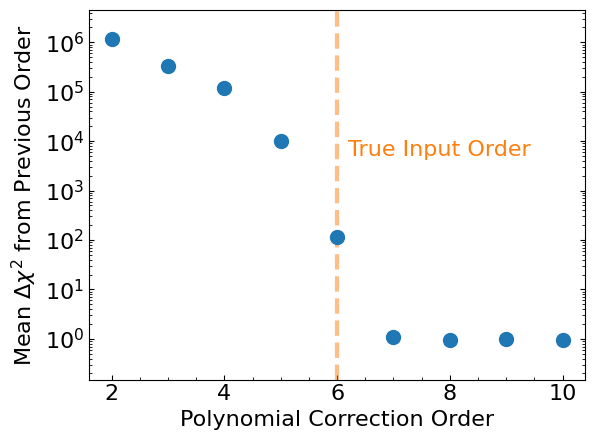

In [5]:
chi2 = [np.mean(chisq) for chisq in chisq_list]

plt.axvline(x=6, linestyle='--', color='C1', alpha=0.5)
plt.ylim(0.15, 4.5e6)
plt.text(6.2, 5e3, "True Input Order", color='C1')
plt.semilogy(order_list[1:], -np.diff(chi2), marker='o', linestyle='', markersize=10)
plt.ylabel("Mean $\Delta\chi^2$ from Previous Order")
plt.xlabel("Polynomial Correction Order")

Now show the error in the nonlinearity correction, since we have fake data and know the true correction.  Do this for many sample pixels so that we can show realizations and means, and uncover biases.

[ 1.00000000e+00  3.98473354e-06  4.12074687e-13 -1.01009413e-15
 -9.96307543e-21  6.00313236e-25]


Text(0.6, 1.35, 'All Ramps, Similar Counts')

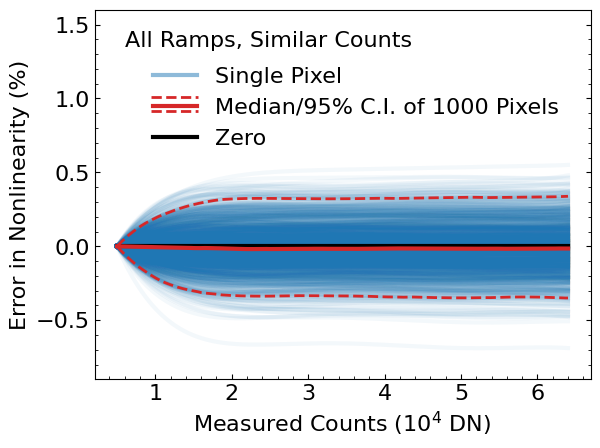

In [6]:
coef_true = [1, 4e-6, -2e-13, -1e-15, -1e-20, 6e-25]
print(np.mean(coefs_list/coefs_list[:, 0][:, None], axis=0))
x = np.linspace(1, 59000, 1000)
coefs_normed = coefs_list/coefs_list[:, 0][:, None]

all_errors = []
for j in range(len(coefs_normed)):
    y_meas = x*coefs_normed[j, 0]
    y_true = x*coef_true[0]
    for i in range(1, coefs_normed.shape[1]):
        y_meas += coefs_normed[j, i]*x**(i + 1)
        y_true += coef_true[i]*x**(i + 1)

    all_errors.append(100*(y_meas/y_true - 1))
    plt.plot((x + 5e3)*1e-4, 100*(y_meas/y_true - 1), alpha=0.05, color='C0')
    
plt.ylim(-0.9, 1.6)
plt.plot(x*0+0.5, x*0, color='C0', label="Single Pixel", alpha=0.5)
plt.ylabel("Error in Nonlinearity (%)") 
plt.plot((x + 5e3)*1e-4, x*0, color='k')
plt.plot((x + 5e3)*1e-4, np.median(np.array(all_errors), axis=0), color='C3', 
         label="Median/95%% C.I. of %d Pixels" % (ramps.shape[-1]))

plt.plot((x + 5e3)*1e-4, stats.scoreatpercentile(np.array(all_errors), 97.5, axis=0),
         color='C3', linewidth=2, linestyle='--')
plt.plot((x + 5e3)*1e-4, stats.scoreatpercentile(np.array(all_errors), 2.5, axis=0), 
         color='C3', linewidth=2, linestyle='--')
#dx = -0.419
dx = -0.151
plt.plot([1.092 + dx, 1.714 + dx], [1.01, 1.01], color='C3', linestyle='--', linewidth=2)
plt.plot([1.092 + dx, 1.714 + dx], [0.915, 0.915], color='C3', linestyle='--', linewidth=2)

# Draw the label now to make it appear at the bottom
plt.plot((x + 5e3)*1e-4, x*0 - 10, color='k', label="Zero")
plt.xlabel("Measured Counts ($10^4$ DN)")
plt.legend(frameon=False, loc=(0.1, 0.6))
plt.text(0.6, 1.35, "All Ramps, Similar Counts")

Compute the correction three different ways to mitigate bias: 
1. Using only read noise
2. Grouping the ramps in batches of similar count rates
3. Using only the saturated ramps

Then make plots of each case using many pixels.

In [7]:
order = 6

ramps_modeled = ramps*1.

res = nonlin.get_nonlin_coefs(ramps[:100], sig, gain, order, pedestal,
                               satval=satval)
ramps_modeled[:100] = getramps(ramps[:100], res, pedestal)

res = nonlin.get_nonlin_coefs(ramps[100:200], sig, gain, order, pedestal,
                               satval=satval)
ramps_modeled[100:200] = getramps(ramps[100:200], res, pedestal)

res = nonlin.get_nonlin_coefs(ramps[200:], sig, gain, order, pedestal,
                               satval=satval)
# The last 100 ramps are the saturated ones with variable count rates.
coefs_onlysat = res.nonlin_coefs/res.nonlin_coefs[:, 0][:, None]

ramps_modeled[200:] = getramps(ramps[200:], res, pedestal)

res = nonlin.get_nonlin_coefs(ramps_modeled, sig, gain, order, pedestal,
                               satval=satval)

coefs_countratesep = res.nonlin_coefs/res.nonlin_coefs[:, 0][:, None]


res = nonlin.get_nonlin_coefs(ramps, sig, np.inf, order, pedestal,
                               satval=satval)

coefs_readnoiseonly = res.nonlin_coefs/res.nonlin_coefs[:, 0][:, None]

(-0.9, 1.6)

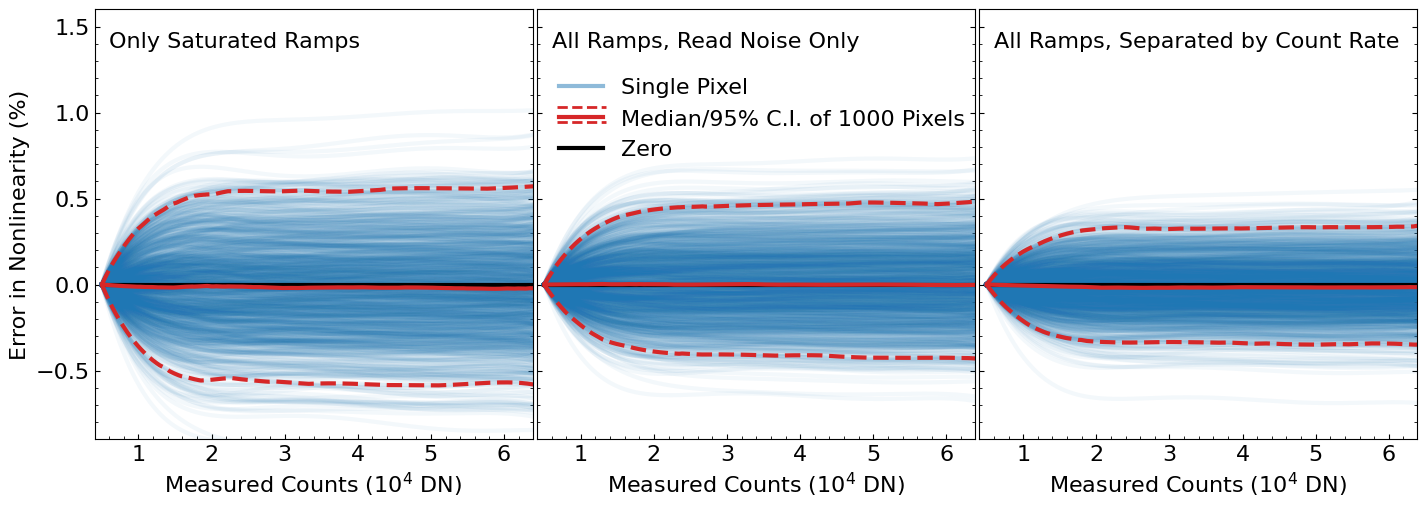

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14.3, 5), sharey=True)
fig.subplots_adjust(wspace=0.01, top=0.98, left=0.065, right=0.99, bottom=0.12)

coef_true = [1, 4e-6, -2e-13, -1e-15, -1e-20, 6e-25]
x = np.linspace(1, 59000, 1000)

error_onlysat = []
error_countratesep = []
error_readnoiseonly = []

for j in range(len(coefs_countratesep)):
    y_countratesep = x*coefs_countratesep[j, 0]
    y_true = x*coef_true[0]
    y_onlysat = x*coefs_onlysat[j, 0]
    y_readnoiseonly = x*coefs_readnoiseonly[j, 0]
    for i in range(1, coefs_countratesep.shape[1]):
        y_countratesep += coefs_countratesep[j, i]*x**(i + 1)
        y_true += coef_true[i]*x**(i + 1)
        y_readnoiseonly += coefs_readnoiseonly[j, i]*x**(i + 1)
    for i in range(1, coefs_onlysat.shape[1]):
        y_onlysat += coefs_onlysat[j, i]*x**(i + 1)

    error_countratesep.append(100*(y_countratesep/y_true - 1))
    error_onlysat.append(100*(y_onlysat/y_true - 1))
    error_readnoiseonly.append(100*(y_readnoiseonly/y_true - 1))
    

for a, err, t in [(ax1, error_onlysat, "Only Saturated Ramps"), 
                 (ax3, error_countratesep, "All Ramps, Separated by Count Rate"),
                 (ax2, error_readnoiseonly, "All Ramps, Read Noise Only")]:

    for j in range(len(err)):
        a.plot(x/1e4+0.5, err[j], alpha=0.05, color='C0')
    
    a.set_xlim(0.4, 6.39)
    a.plot(x*0+0.5, x*0, color='C0', label="Single Pixel", alpha=0.5)
    a.plot(x/1e4+0.5, x*0, color='k')
    a.plot(x/1e4+0.5, np.median(np.array(err), axis=0), color='C3', label="Median/95%% C.I. of %d Pixels" % (ramps.shape[-1]))
    a.plot(x/1e4+0.5, x*0 - 10, color='k', label='Zero')
    a.text(0.6, 1.38, t)
    a.set_xlabel("Measured Counts ($10^4$ DN)")

    a.plot(x/1e4+0.5, np.sort(np.array(err), axis=0)[25], color='C3', linestyle='--')
    a.plot(x/1e4+0.5, np.sort(np.array(err), axis=0)[-25], color='C3', linestyle='--')

ax1.set_ylabel("Error in Nonlinearity (%)")
ax2.legend(frameon=False, loc=(0.03, 0.63))
dx = -0.419
ax2.plot([1.092 + dx, 1.757 + dx], [1.03, 1.03], color='C3', linestyle='--', linewidth=2)
ax2.plot([1.092 + dx, 1.757 + dx], [0.945, 0.945], color='C3', linestyle='--', linewidth=2)

ax1.set_ylim(-0.9, 1.6)

In [9]:
# Canipe algorithm doesn't play nicely with many ramps.  Average them together.

meanramps = np.mean(ramps, axis=0)
iread = np.arange(meanramps.shape[0])
# Only use the ramps up to saturation.
max_i = np.amax(iread[np.median(meanramps, axis=1) < satval - 500])
meanramps = meanramps[:max_i]

# First step in the Canipe algorithm: fit a low-order polynomial to the first few reads.

order = 2
t = np.arange(10) + 1
quad_arr = np.ones((10, order + 1))
quad_arr[:, 1] = t
for i in range(2, order + 1):
    quad_arr[:, i] = t**i

estctrates = np.linalg.lstsq(quad_arr, meanramps[:10, :], rcond=None)[0][1]

# Second step: full correction assuming the count rates from above.

order = 6
poly_arr = np.ones((meanramps.shape[0], order + 1))

coefs_canipe = []
for k in range(meanramps.shape[1]):
    y = (meanramps[:, k] - pedestal[k])*1e-4
    poly_arr[:, 1] = y
    for i in range(2, order + 1):
        poly_arr[:, i] = y**i
        
    iread = np.arange(meanramps.shape[0])
    coef = np.linalg.lstsq(poly_arr, iread*estctrates[k]*1e-4, rcond=None)[0]
    coefs_canipe.append(coef[1:]/coef[1]*1e-4**(np.arange(0, len(coef) - 1)))

coefs_canipe = np.array(coefs_canipe)

## The cell below should only be run (the figure is only meaningful) if the count rates are the same.

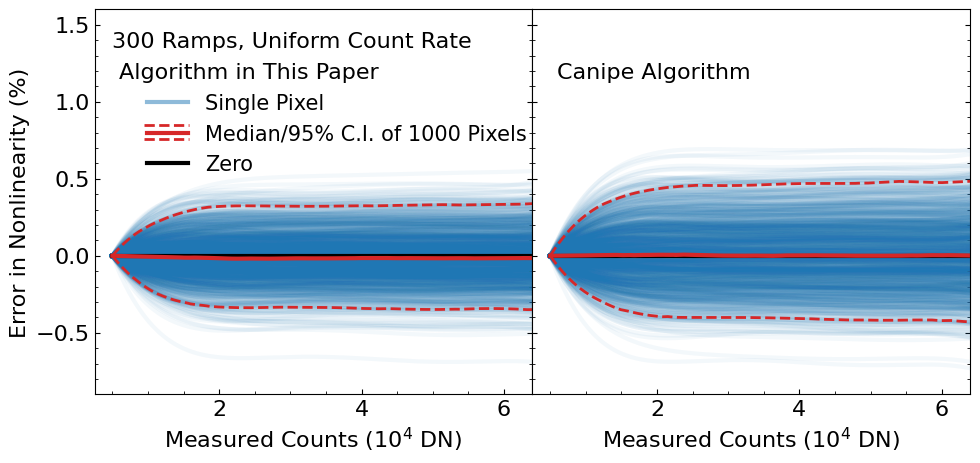

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.3, 5), sharey=True)
fig.subplots_adjust(wspace=0.0)

coef_true = [1, 4e-6, -2e-13, -1e-15, -1e-20, 6e-25]
x = np.linspace(1, 59000, 1000)

errs_newalgo = []
errs_canipe = []

for j in range(len(coefs_canipe)):
    y_canipe = x*coefs_canipe[j, 0]
    y_true = x*coef_true[0]
    y_newalgo = x*coefs_normed[j, 0]
    for i in range(1, coefs_canipe.shape[1]):
        y_canipe += coefs_canipe[j, i]*x**(i + 1)
        y_true += coef_true[i]*x**(i + 1)
    for i in range(1, coefs_normed.shape[1]):
        y_newalgo += coefs_normed[j, i]*x**(i + 1)

    errs_canipe.append(100*(y_canipe/y_true - 1))
    errs_newalgo.append(100*(y_newalgo/y_true - 1))
    ax1.plot(x/1e4+0.5, 100*(y_newalgo/y_true - 1), alpha=0.05, color='C0')
    ax2.plot(x/1e4+0.5, 100*(y_canipe/y_true - 1), alpha=0.05, color='C0')
    
for (ax, err) in [(ax1, errs_newalgo), (ax2, errs_canipe)]:
    ax.plot(x*0+0.5, x*0, color='C0', label="Single Pixel", alpha=0.5)
    ax.plot(x/1e4+0.5, x*0, color='k')
    ax.plot(x/1e4+0.5, np.median(np.array(err), axis=0), color='C3', label="Median/95%% C.I. of %d Pixels" % (ramps.shape[-1]))
    ax.plot(x/1e4+0.5, x*0 - 10, color='k', label='Zero')

    ax.plot((x + 5e3)*1e-4, stats.scoreatpercentile(np.array(err), 97.5, axis=0), color='C3', linewidth=2, linestyle='--')
    ax.plot((x + 5e3)*1e-4, stats.scoreatpercentile(np.array(err), 2.5, axis=0), color='C3', linewidth=2, linestyle='--')

    ax.set_xlim(0.25, 6.4)
    ax.set_ylim(-0.9, 1.6)
    ax.set_xlabel("Measured Counts ($10^4$ DN)")

dx = -0.144
ax1.plot([1.095 + dx, 1.724 + dx], [0.847, 0.847], color='C3', linestyle='--', linewidth=2)
ax1.plot([1.095 + dx, 1.724 + dx], [0.757, 0.757], color='C3', linestyle='--', linewidth=2)
ax1.set_ylabel("Error in Nonlinearity (%)")
ax1.legend(frameon=False, loc=(0.1, 0.55), fontsize=15)

ax1.text(0.5, 1.35, "300 Ramps, Uniform Count Rate")
ax1.text(0.6, 1.15, "Algorithm in This Paper")
ax2.text(0.6, 1.15, "Canipe Algorithm")
plt.show()